# Laboratorium

### Konfiguracja

In [74]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [75]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


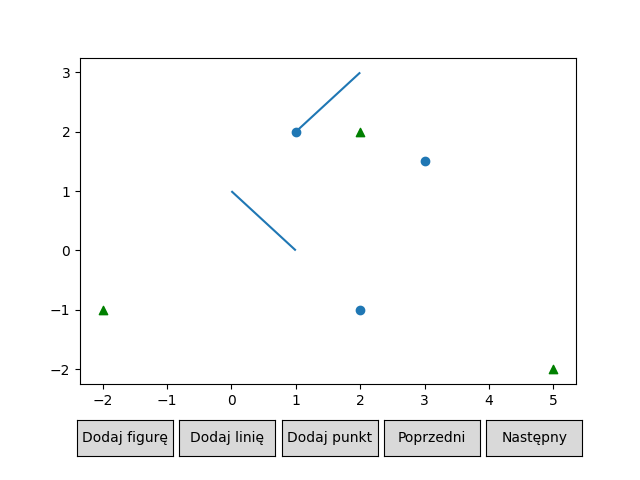

In [25]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


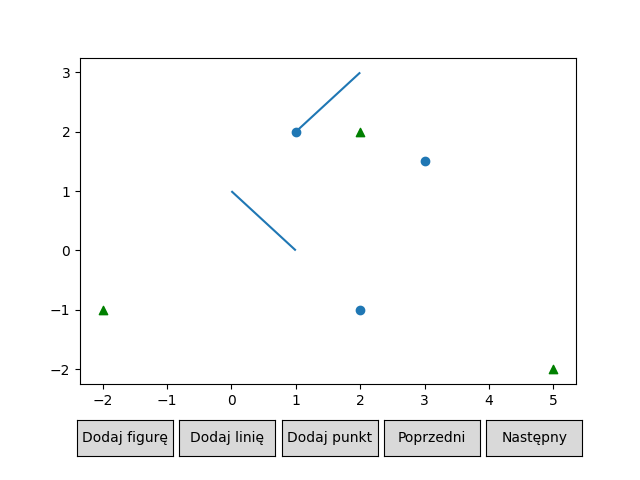

In [26]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


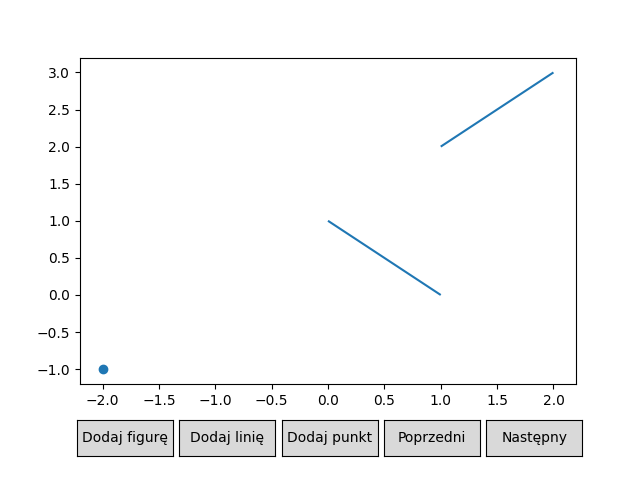

In [27]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


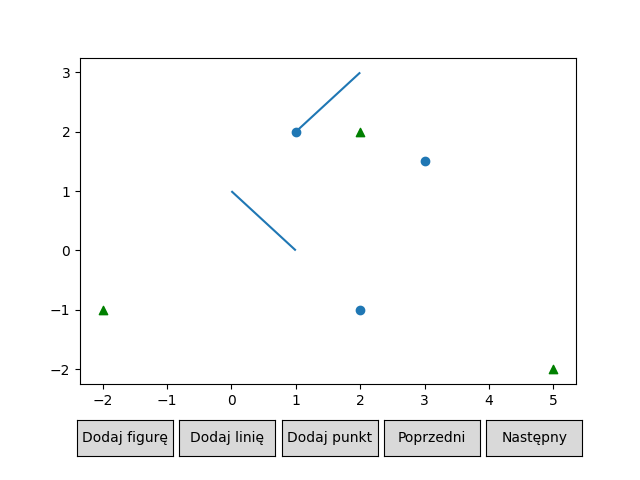

In [28]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


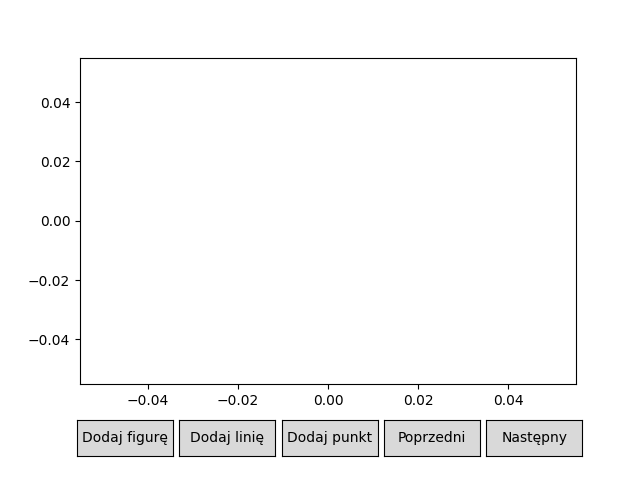

In [29]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Rozwiązanie

## Generacja punktów

#### Zbiór A

<IPython.core.display.Javascript object>


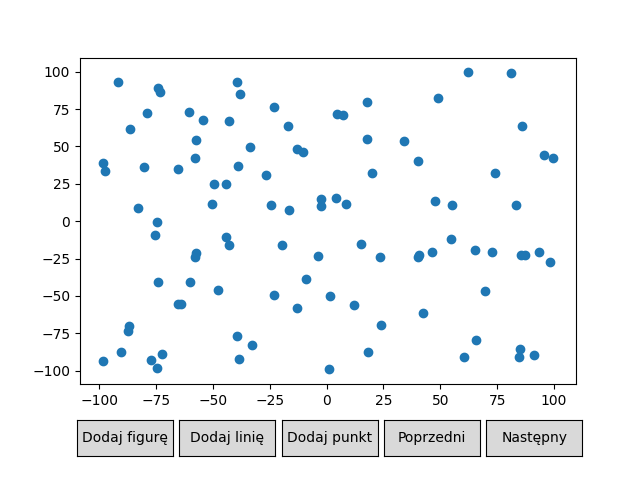

In [33]:
%matplotlib notebook
from random import uniform as uni
dataA = [(uni(-100, 100), uni(-100, 100)) for _ in range(100)]
Plot(points=[PointsCollection(dataA)]).draw()


#### Dane B

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


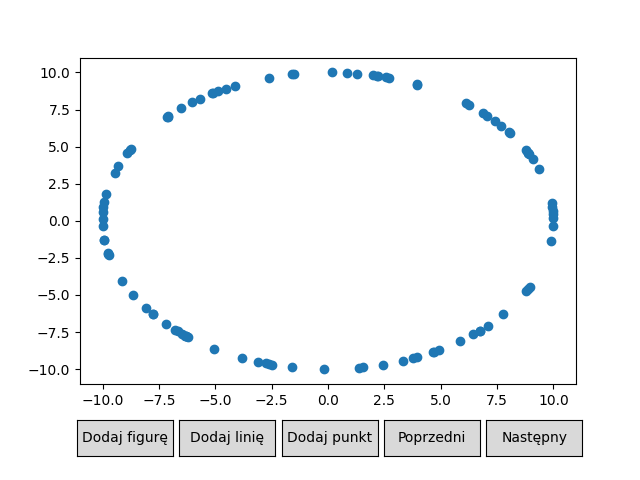

In [34]:
dataB = [(lambda x : (10 * np.cos(np.pi * x), 10 * np.sin(np.pi * x)))(uni(0, 2)) for _ in range(100)]
Plot(points=[PointsCollection(dataB)]).draw()

#### Dane C

<IPython.core.display.Javascript object>


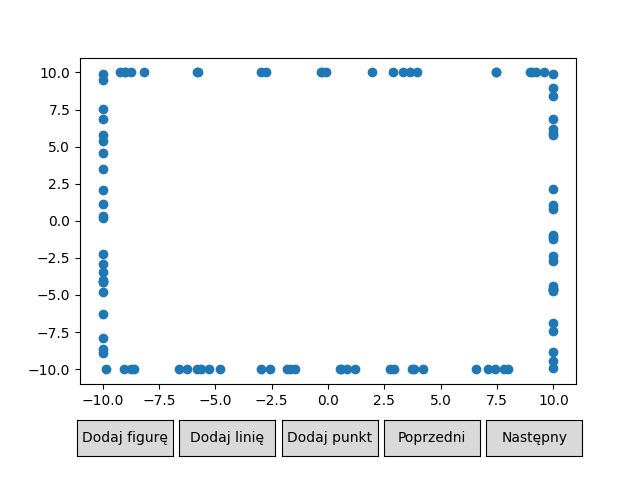

In [39]:
import random

def genOnSquare():
    side = random.choice([0, 1, 2, 3])
    pos = uni(-10, 10)
    if side == 0: return -10, pos
    elif side == 1: return 10, pos
    elif side == 2: return pos, -10
    else: return pos, 10
dataC = [genOnSquare() for _ in range(100)]
Plot(points=[PointsCollection(dataC)]).draw()

#### Dane D

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


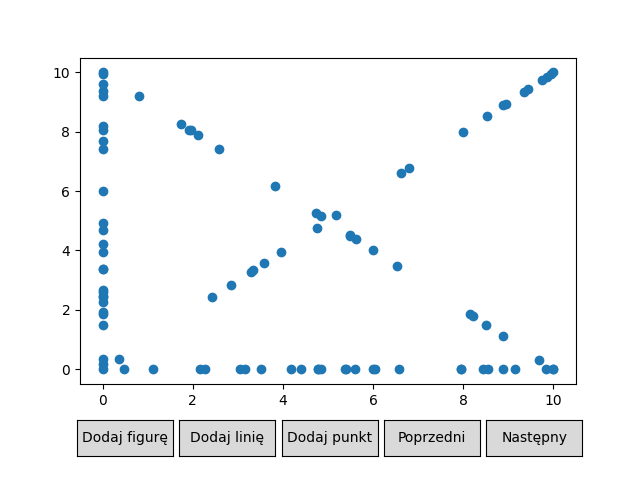

In [40]:
dataD = [(0, 0), (10, 0), (10, 10), (0, 10)]
for _ in range(25):
    dataD.append((0, uni(0, 10)))
    dataD.append((uni(0, 10), 0))
for _ in range(20):
    dataD.append((lambda x:(x, x)) (uni(0, 10)))
    dataD.append((lambda x:(x, 10 - x)) (uni(0,10)))
Plot(points=[PointsCollection(dataD)]).draw()

In [360]:
def genDataA(quantity, minX=-10, maxX=10, minY=-10, maxY=10):
    return [(uni(minX, maxX), uni(minY, maxY)) for _ in range(quantity)]

def genDataB(quantity, centreX=0, centreY=0, radious=100):
    return [(lambda x : (radious * np.cos(np.pi * x) +centreX, radious * np.sin(np.pi * x)+centreY))(uni(0, 2)) for _ in range(quantity)]

def genDataC(quantity, vertices=[(-10, -10), (20, -10), (20, 0), (-10, 0)]): # vertices = [bottomLeft, bottomRight, upperRight, upperLeft]
    output = []
    bottomLeft = vertices[0]
    upperRight = vertices[2]
    aLen = upperRight[0] - bottomLeft[0]
    bLen = upperRight[1] - bottomLeft[1]
    aProb = aLen / (aLen + bLen)
    for _ in range(quantity):
        choice = random.randint(0, 1)
        if aProb > uni(0,1):
            if choice == 0:
                output.append((uni(bottomLeft[0], upperRight[0]), bottomLeft[1]))
            else:
                output.append((uni(bottomLeft[0], upperRight[0]), upperRight[1]))
        else:
            if choice == 0:
                output.append((bottomLeft[0], uni(bottomLeft[1], upperRight[1])))
            else:
                output.append((upperRight[0], uni(bottomLeft[1], upperRight[1])))
    return output

# rect = [(-10, -10), (20, -10), (20, 0), (-10, 0)]
# Plot(points=[PointsCollection(genDataC(10, rect))]).draw()

def genDataD(axisQuantity, diagonalQuantity, square=[(7, 5), (12, 5), (12, 10), (7, 10)]): # vertices = [bottomLeft, bottomRight, upperRight, upperLeft]
    vertices=square.copy()
    bottomLeft, upperRight = vertices[0], vertices[2]
    
    for _ in range(axisQuantity):
        vertices.append((uni(bottomLeft[0], upperRight[0]), bottomLeft[1]))
        vertices.append((bottomLeft[0], uni(bottomLeft[1], upperRight[1])))
    a = (bottomLeft[1] - upperRight[1])/(bottomLeft[0] - upperRight[0])
    b = bottomLeft[1] - a * bottomLeft[0]
    b2 = vertices[1][1] + a * vertices[1][0]
    for _ in range(diagonalQuantity):
        r1, r2 = uni(bottomLeft[0], upperRight[0]), uni(bottomLeft[0], upperRight[0])
        vertices.append((r1, a * r1 + b))
        vertices.append((r2, -a * r2 + b2))
    return vertices
# square = [(7, 5), (12, 5), (12, 10), (7, 10)]
# test = genDataD(5, 5, square)
# Plot(points=[PointsCollection(test)]).draw()


## Funkcje pomocnicze

In [169]:
from collections import deque
import time

def det(a, b, c, epsilon = 1e-12): # gdzie leży punkt c względem prostej ab
    det = a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - (c[0] * b[1] + c[1] * a[0] + b[0] * a[1])
    if abs(det) < epsilon:
        return 0 # na prostej
    elif det < 0:
        return -1 # na prawo od prostej
    else:
        return 1 # na lewo od prostej

def dist(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

def partition(array, low, high, origin): # ta wersja nie usuwa punktów współliniowych
    pivot = array[high]
    i = low - 1
    for j in range(low, high):
        if det(origin, array[j], pivot) > 0 or (det(origin, array[j], pivot) == 0 and dist(origin, array[j]) <= dist(origin,pivot)):
            i = i + 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[high] = array[high], array[i + 1]
    return i + 1
 
def quickSort(array, low, high, origin):
    if low < high:
        pi = partition(array, low, high, origin)
        quickSort(array, low, pi - 1, origin)
        quickSort(array, pi + 1, high, origin)

def toLines(points):
    points = list(points)
    if len(points) < 2:
        return []
    output = []
    for i in range(1, len(points)):
        output.append((points[i-1], points[i]))
    return output


## Algorytm Grahama

In [399]:
def grahamBasic(dataset, writeToFile=False):
    points = dataset.copy()
    random.shuffle(points)
    t = time.time()
    origin = min(points, key=lambda x : (x[1], x[0]))
    points.remove(origin)
    quickSort(points, 0, len(points)-1, origin)
    points.insert(0, origin)
#     print("GrahamBasic time of sorting = ", time.time()-t)
    stack = deque()
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])
    for point in points[3:]:
        while len(stack) > 1 and det(stack[-2], stack[-1], point) != 1:
            stack.pop()
        stack.append(point)

    if writeToFile:
        f=open("textoutput/grahamBasicOutput.txt", "w")
        f.write(str(stack))
    return list(stack), time.time() - t

def grahamPointFilter(dataset, writeToFile=False):
    points = dataset.copy()
    t = time.time()
    origin = min(points, key=lambda x : (x[1], x[0]))
    points.remove(origin)
    quickSort(points, 0, len(points)-1, origin)
    points.insert(0, origin)
    sortTime = time.time()
#     print("GrahamPointFilter time of sorting = ", sortTime - t)
    pointsFilter = [origin]
    for i in range(1, len(points) - 1):
        if det(origin, points[i], points[i+1]) == 0 or dist(points[i], points[i+1]) == 0:
            continue
        pointsFilter.append(points[i])
    pointsFilter.append(points[-1])
    filterTime = time.time() - sortTime
#     print("GrahamPointFilter time of filtering = ", sortTime - t)
    stack = deque()
    stack.append(pointsFilter[0])
    stack.append(pointsFilter[1])
    stack.append(pointsFilter[2])
    for point in pointsFilter[3:]:
        while len(stack) > 1 and det(stack[-2], stack[-1], point) != 1:
            stack.pop()
        stack.append(point)

    if writeToFile:
        f=open("textoutput/grahamPointFilterOutput.txt", "w")
        f.write(str(stack))
    return list(stack), time.time() - t

# a = grahamPointFilter(genDataC(50))[0]
# print(len(a))
# plot = Plot(points=[PointsCollection(a)])
# plot.draw()

## Algorytm Jarvisa

In [266]:
def jarvisBasic(dataset, writeToFile=False):
    points = dataset.copy()
    t = time.time()
    origin = min(points, key=lambda x : (x[1], x[0]))
    hull = [origin]
    hullSet = set(origin)
    hullElement = None
    for point in points:
        if point != origin:
            hullElement = point
            break
    for point in points:
        if point == origin: continue
        if det(origin, hullElement, point) == -1 or (det(origin, hullElement, point) == 0 and dist(origin, hullElement) < dist(origin, point)):
            hullElement = point
    hull.append(hullElement)
    while True:
        candidate = origin
        for point in points:
            if point == hullElement or point in hullSet: continue
            if det(hullElement, candidate, point) == -1 or (det(hullElement, candidate, point) == 0 and dist(hullElement, candidate) < dist(hullElement, point)):
                candidate = point
        if candidate == origin: break
        hull.append(candidate)
        hullSet.add(candidate)
        hullElement = candidate
    if writeToFile:
        f=open("textoutput/jarvisBasic.txt", "w")
        f.write(str(hull))
    return hull, time.time() - t

## Algorytm Grahama podstawowy - zaznaczanie otoczki

In [167]:
def grahamBasicDraw(dataset):
    points=dataset.copy()
    scenes = []
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points)]))
    origin = min(points, key=lambda x : (x[1], x[0]))
    points.remove(origin)
    quickSort(points, 0, len(points)-1, origin)
    points.insert(0, origin)
    stack = deque()
    stack.append(points[0])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[1:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    stack.append(points[1])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[2:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    stack.append(points[2])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[3:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    for i in range(3, len(points)):
        while len(stack) > 1 and det(stack[-2], stack[-1], points[i]) != 1:
            scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
            stack.pop()
        scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
        stack.append(points[i])
        scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
    scenes.append(Scene([PointsCollection(points, color='lightgray'), 
                        PointsCollection(list(stack), color='red')],
                [LinesCollection(toLines(stack)+[(stack[0], stack[-1])])]))
    return scenes


#### Przykład użycia

<IPython.core.display.Javascript object>


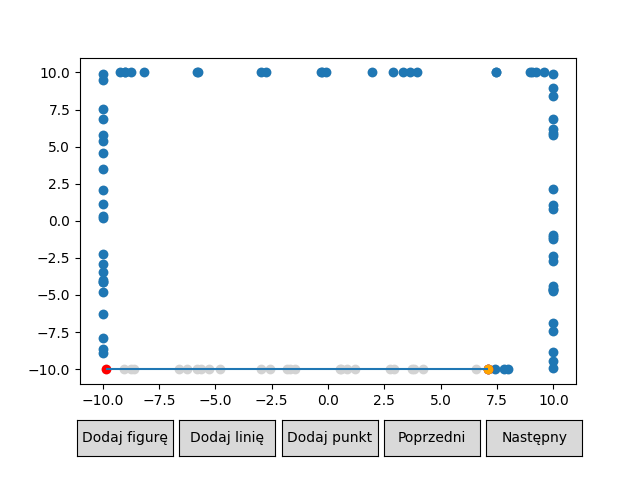

In [170]:
a = grahamBasicDraw(dataC)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


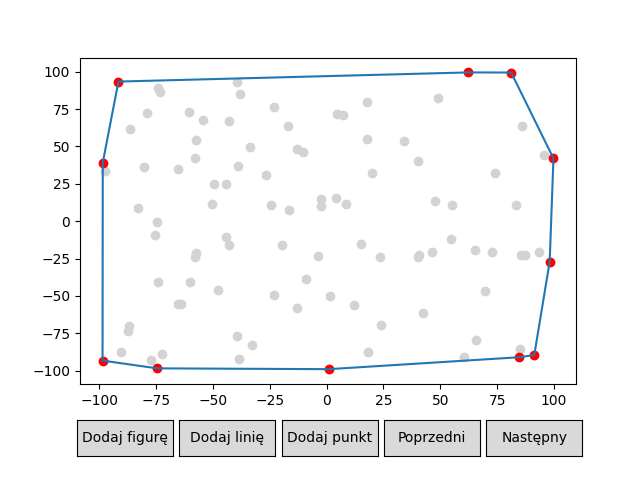

In [180]:
## Dane A
a = grahamBasicDraw(dataA)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


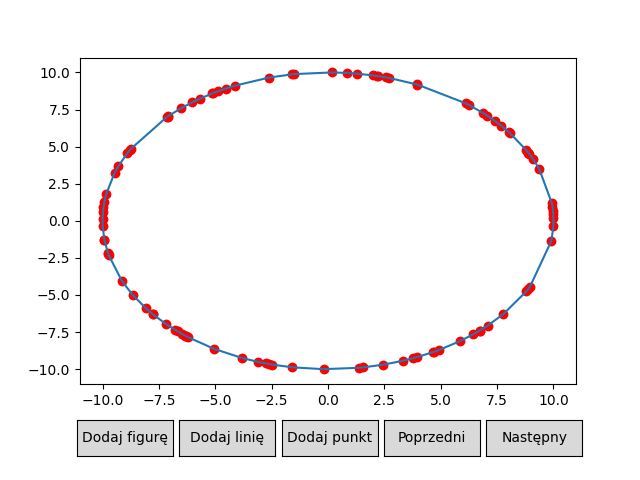

In [178]:
a = grahamBasicDraw(dataB)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


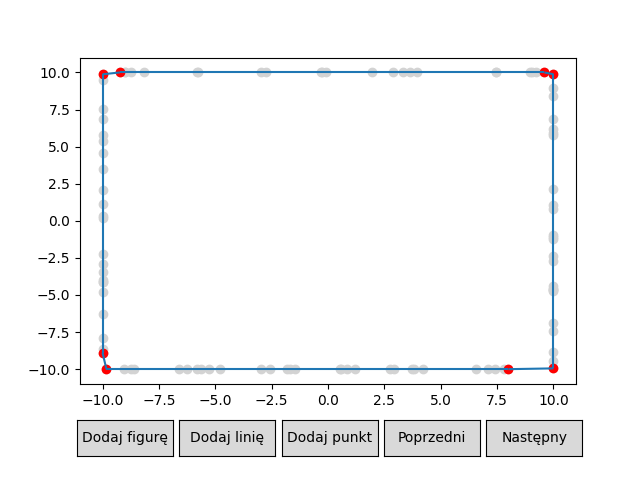

In [179]:
a = grahamBasicDraw(dataC)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


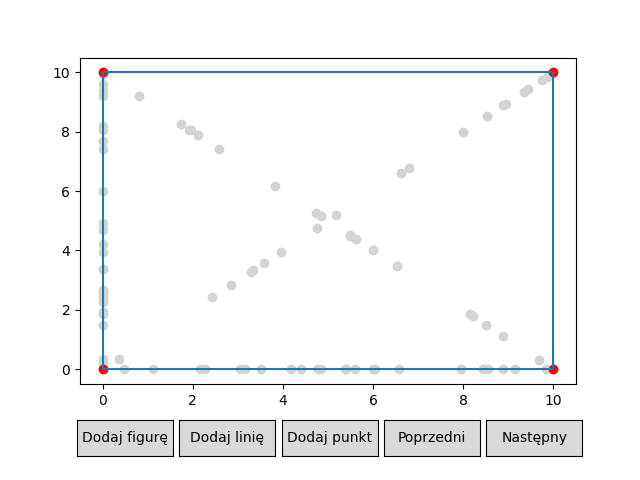

In [181]:
a = grahamBasicDraw(dataD)
plot = Plot(scenes=a)
plot.draw()

## Algorytm Grahama podstawowy - generowanie obrazów z otoczką

In [188]:
def grahamBasicToImg(dataset):
    points=dataset.copy()
    j = 0
    scenes = []
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points)]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{j}pic")
    j+=1
    origin = min(points, key=lambda x : (x[1], x[0]))
    points.remove(origin)
    quickSort(points, 0, len(points)-1, origin)
    points.insert(0, origin)
    stack = deque()
    stack.append(points[0])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[1:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{j}pic")
    j+=1
    stack.append(points[1])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[2:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{j}pic")
    j+=1
    stack.append(points[2])
    scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[3:]), 
                             PointsCollection(list(stack), color='red')],
                       [LinesCollection(toLines(stack))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{j}pic")
    j+=1
    for i in range(3, len(points)):
        while len(stack) > 1 and det(stack[-2], stack[-1], points[i]) != 1:
            scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
            toplot = [scenes[-1]]
            plot = Plot(scenes=toplot)
            plot.draw()
            plt.savefig(f"pic/{j}pic")
            j+=1
            stack.pop()
        scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
        toplot = [scenes[-1]]
        plot = Plot(scenes=toplot)
        plot.draw()
        plt.savefig(f"pic/{j}pic")
        j+=1
        stack.append(points[i])
        scenes.append(Scene([PointsCollection(points, color='lightgray'), PointsCollection(points[i:]), 
                             PointsCollection(list(stack), color='red'), PointsCollection([points[i]], color='orange')],
                       [LinesCollection(toLines(stack))]))
        toplot = [scenes[-1]]
        plot = Plot(scenes=toplot)
        plot.draw()
        plt.savefig(f"pic/{j}pic")
        j+=1
    scenes.append(Scene([PointsCollection(points, color='lightgray'), 
                        PointsCollection(list(stack), color='red')],
                [LinesCollection(toLines(stack)+[(stack[0], stack[-1])])]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{j}pic")
    j+=1
    print(stack[-1])
    return scenes

# grahamBasicToImg(dataA)

## Algorytm Jarvisa - zaznaczanie otoczki


In [267]:
def jarvisBasicDraw(points):
    points = points
    random.shuffle(points)
    scenes = []
    origin = min(points, key=lambda x : (x[1], x[0]))
    hull = [origin]
    hullSet = set(origin)
    scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red')],
                       [LinesCollection(toLines(hull))]))
    hullElement = None
    for point in points:
        if point != origin:
            hullElement = point
            break
    scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([hullElement], color='orange')],
                       [LinesCollection(toLines(hull+[hullElement]))])) 
    for point in points:
        if point == origin: continue
        scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([hullElement], color='orange'),
                        PointsCollection([point], color='yellow')],
                       [LinesCollection(toLines(hull+[hullElement]))])) 
        if det(origin, hullElement, point) == -1 or (det(origin, hullElement, point) == 0 and dist(origin, hullElement) < dist(origin, point)):
            hullElement = point
    hull.append(hullElement)
    scenes.append(Scene([PointsCollection(points), 
                PointsCollection(hull.copy(), color='red'),
                PointsCollection([hullElement], color='orange')],
               [LinesCollection(toLines(hull))]))

    while True:
        
        candidate = origin
        for point in points:
            if point == hullElement or point in hullSet: continue
            scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([candidate], color='orange'),
                        PointsCollection([point], color='yellow')],
                       [LinesCollection(toLines(hull+[candidate]))]))           
            if det(hullElement, candidate, point) == -1 or (det(hullElement, candidate, point) == 0 and dist(hullElement, candidate) < dist(hullElement, point)):
                candidate = point
        
        
        if candidate == origin: break
        hull.append(candidate)
        hullSet.add(candidate)
        hullElement = candidate
    scenes.append(Scene([PointsCollection(points), 
                PointsCollection(hull.copy(), color='red')],
               [LinesCollection(toLines(hull+[hull[0]]))]))
    return scenes


C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


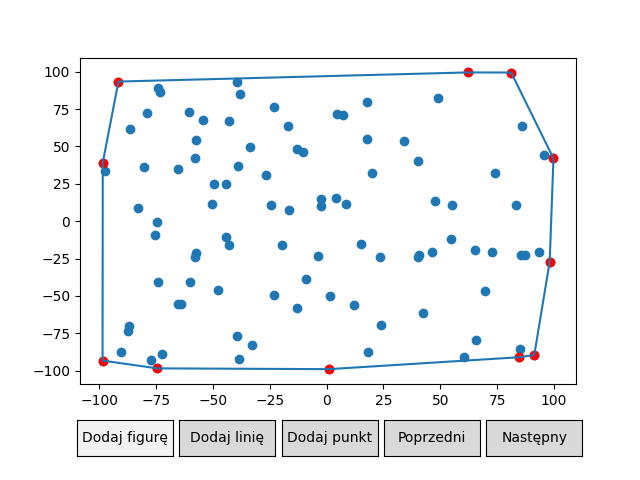

In [183]:
## Dane A
a = jarvisBasicDraw(dataA)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


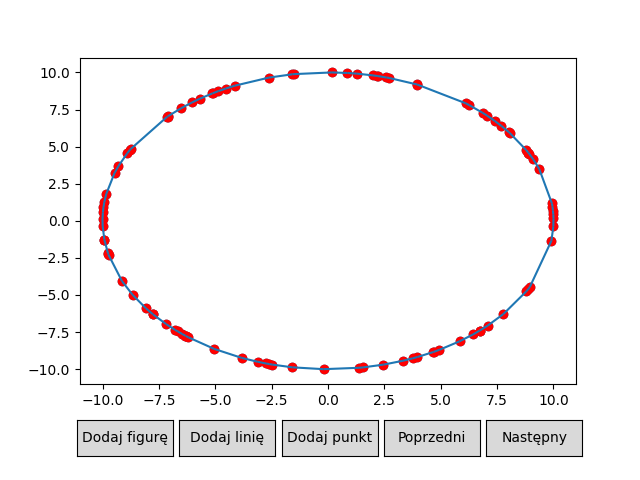

In [184]:
a = jarvisBasicDraw(dataB)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


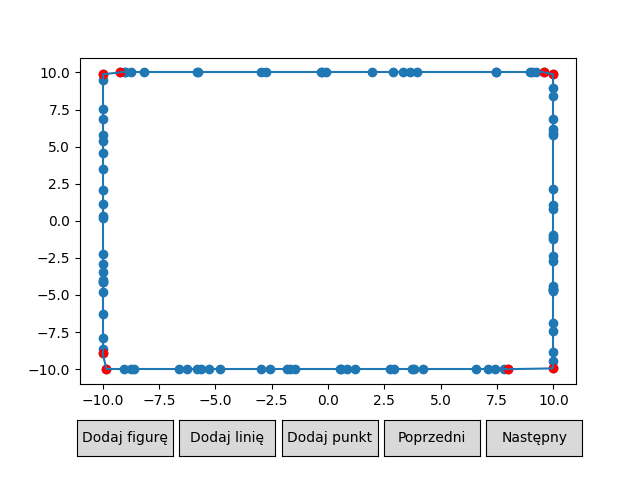

In [185]:
a = jarvisBasicDraw(dataC)
plot = Plot(scenes=a)
plot.draw()

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


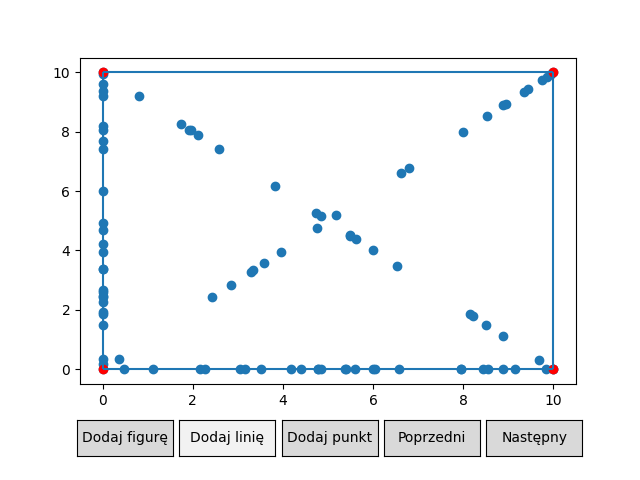

In [186]:
a = jarvisBasicDraw(dataD)
plot = Plot(scenes=a)
plot.draw()

## Algorytm Jarvisa - generowanie obrazów

In [213]:
def jarvisBasicToImg(points):
    i = 0
    points = points
    random.shuffle(points)
    scenes = []
    origin = min(points, key=lambda x : (x[1], x[0]))
    hull = [origin]
    scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red')],
                       [LinesCollection(toLines(hull))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{i}pic")
    i+=1
    hullElement = None
    for point in points:
        if point != origin:
            hullElement = point
            break
    scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([hullElement], color='orange')],
                       [LinesCollection(toLines(hull+[hullElement]))])) 
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{i}pic")
    i+=1
    for point in points:
        if point == origin: continue
        scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([hullElement], color='orange'),
                        PointsCollection([point], color='yellow')],
                       [LinesCollection(toLines(hull+[hullElement]))])) 
        toplot = [scenes[-1]]
        plot = Plot(scenes=toplot)
        plot.draw()
        plt.savefig(f"pic/{i}pic")
        i+=1
        if det(origin, hullElement, point) == -1 or (det(origin, hullElement, point) == 0 and dist(origin, hullElement) < dist(origin, point)):
            hullElement = point
    hull.append(hullElement)
    scenes.append(Scene([PointsCollection(points), 
                PointsCollection(hull.copy(), color='red'),
                PointsCollection([hullElement], color='orange')],
               [LinesCollection(toLines(hull))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{i}pic")
    i+=1
    while True:
        
        candidate = origin
        for point in points:
            
            if point == hullElement: continue
            scenes.append(Scene([PointsCollection(points), 
                        PointsCollection(hull.copy(), color='red'),
                        PointsCollection([candidate], color='orange'),
                        PointsCollection([point], color='yellow')],
                       [LinesCollection(toLines(hull+[candidate]))]))
            toplot = [scenes[-1]]
            plot = Plot(scenes=toplot)
            plot.draw()
            plt.savefig(f"pic/{i}pic")
            i+=1           
            if det(hullElement, candidate, point) == -1 or (det(hullElement, candidate, point) == 0 and dist(hullElement, candidate) < dist(hullElement, point)):
                candidate = point
        
        
        if candidate == origin: break
        hull.append(candidate)
        hullElement = candidate
    scenes.append(Scene([PointsCollection(points), 
                PointsCollection(hull.copy(), color='red')],
               [LinesCollection(toLines(hull+[hull[0]]))]))
    toplot = [scenes[-1]]
    plot = Plot(scenes=toplot)
    plot.draw()
    plt.savefig(f"pic/{i}pic")
    i+=1
    return scenes

# jarvisBasicToImg(dataD)

## Sprawdzanie poprawności

C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


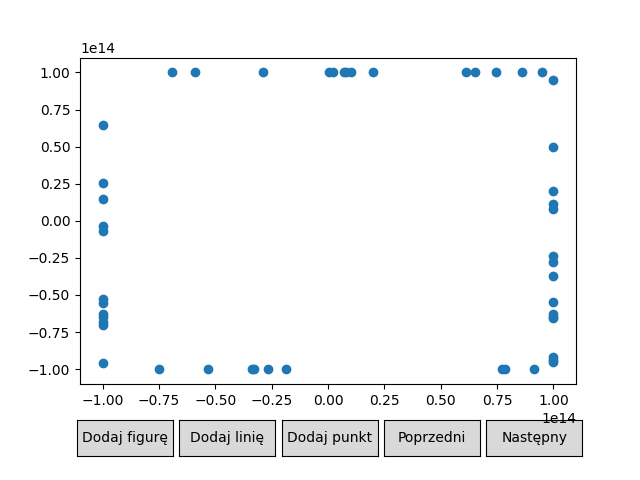

In [295]:
rect = [(-1e14, -1e14), (1e14,-1e14), (1e14, 1e14), (-1e14,1e14)]
bigrect = genDataC(50, rect)
plot = Plot(points=[PointsCollection(bigrect)])
plot.draw()

[(-74828066810464.06, -100000000000000.0), (-18565108031027.47, -100000000000000.0), (100000000000000.0, -95388795245942.53), (100000000000000.0, 95086327301527.38), (95058614132599.03, 100000000000000.0), (-28651021431788.53, 100000000000000.0), (-69019096400025.016, 100000000000000.0), (-100000000000000.0, 64865979641902.19), (-100000000000000.0, -95615566897828.11)] 9


<IPython.core.display.Javascript object>


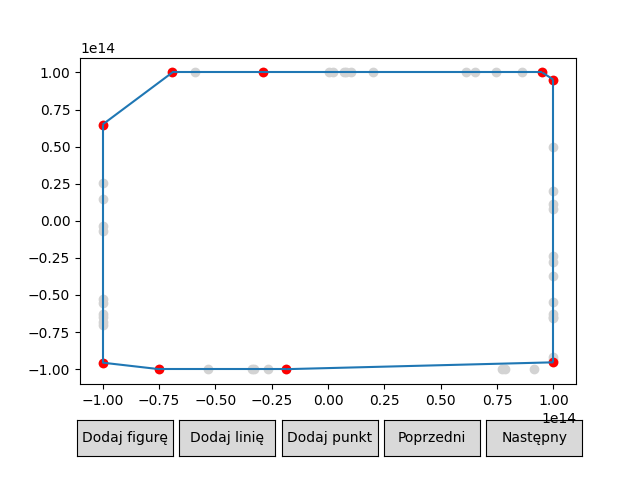

In [297]:
grahamBig = grahamBasicDraw(bigrect)
print(grahamBasic(bigrect)[0], len(grahamBasic(bigrect)[0]))
plot = Plot(scenes=grahamBig)
plot.draw()

11


<IPython.core.display.Javascript object>


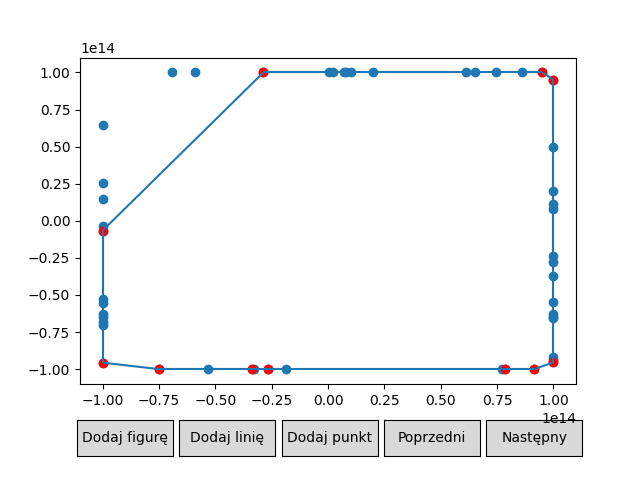

In [301]:
jarvisBig = jarvisBasicDraw(bigrect)
print(len(jarvisBasic(bigrect)[0]))
plot = Plot(scenes=jarvisBig)
plot.draw()

<IPython.core.display.Javascript object>


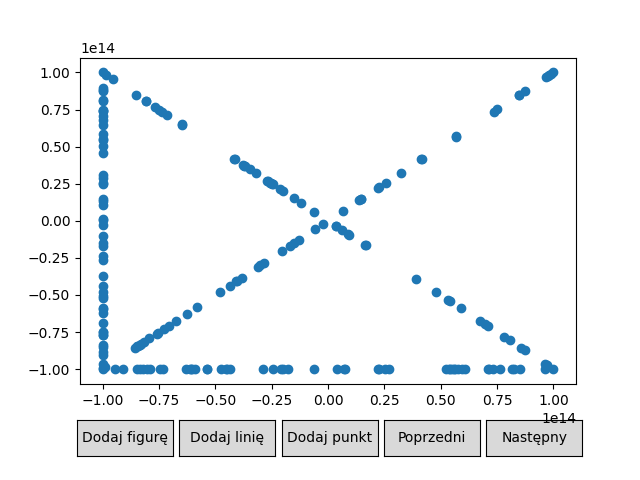

In [281]:
rect = [(-1e14, -1e14), (1e14,-1e14), (1e14, 1e14), (-1e14,1e14)]
bigrect = genDataD(50, 50, rect)
plot = Plot(points=[PointsCollection(bigrect)])
plot.draw()

5


C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


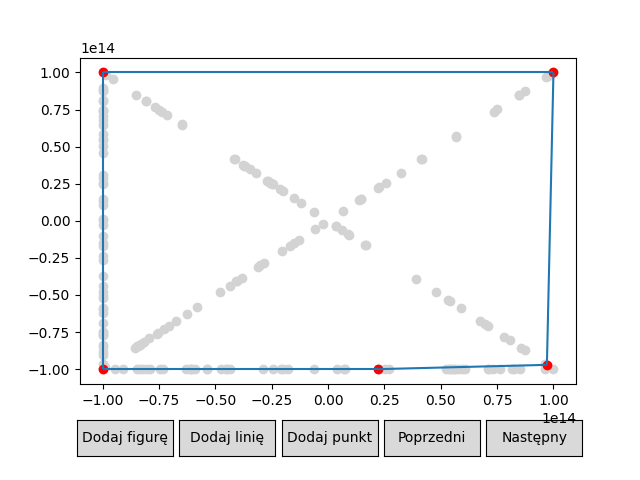

In [285]:
grahamBig = grahamBasicDraw(bigrect)
print(len(grahamBasic(bigrect)[0]))
plot = Plot(scenes=grahamBig)
plot.draw()

5


C:\Users\Domin\AppData\Local\Temp\ipykernel_56068\2664771801.py:121: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


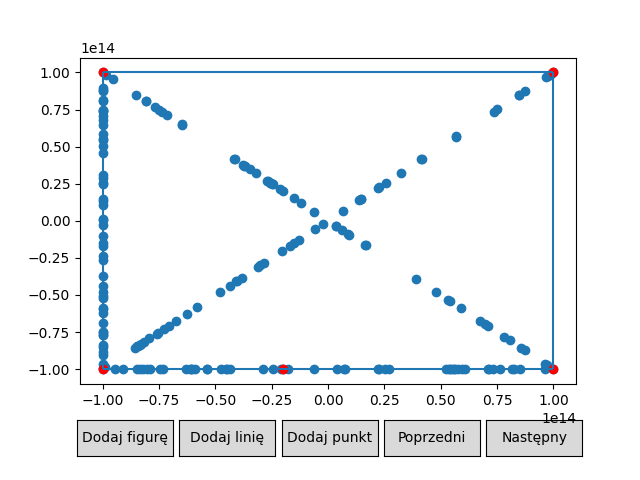

In [284]:
jarvisBig = jarvisBasicDraw(bigrect)
print(len(jarvisBasic(bigrect)[0]))
plot = Plot(scenes=jarvisBig)
plot.draw()

In [318]:
circleSet = genDataB(1500, 0, 0, 1)

In [322]:
print(len(grahamBasic(circleSet)[0]))
print(len(jarvisBasic(circleSet)[0]))
for i in range(len(circleSet)):
    for j in range(len(circleSet)):
        if i == j: continue
        if circleSet[i] == circleSet[j]:
            print(circleSet)

1494
1494


## Porównanie czasów

In [373]:
testRect = [(0, 0), (10, 0), (10, 10), (0, 10)]
print(len(testRect))
quantities = [100, 1000, 5000, 10000, 15000, 30000, 50000]
dataNames = ["dataA", "dataB", "dataC", "dataD"]
sets = [[genDataA(qua), genDataB(qua), genDataC(qua, testRect), genDataD(qua, qua, testRect)] for qua in quantities]


4


In [374]:
print("DATA A")
for qua in range(len(quantities)):
    print("quantity: ", quantities[qua])
    print("grahamTime: ", grahamBasic(sets[qua][0])[1])
    print("grahamFilterTime: ", grahamPointFilter(sets[qua][0])[1])
    print("jarvisTime: ", jarvisBasic(sets[qua][0])[1])

DATA A
quantity:  100
grahamTime:  0.008031368255615234
grahamFilterTime:  0.0
jarvisTime:  0.0
quantity:  1000
grahamTime:  0.016124248504638672
grahamFilterTime:  0.024010419845581055
jarvisTime:  0.03243446350097656
quantity:  5000
grahamTime:  0.08700680732727051
grahamFilterTime:  0.1107020378112793
jarvisTime:  0.16736817359924316
quantity:  10000
grahamTime:  0.19093036651611328
grahamFilterTime:  0.22078943252563477
jarvisTime:  0.4047379493713379
quantity:  15000
grahamTime:  0.32785797119140625
grahamFilterTime:  0.35334134101867676
jarvisTime:  0.540168285369873
quantity:  30000
grahamTime:  0.7636973857879639
grahamFilterTime:  0.8222887516021729
jarvisTime:  1.5085604190826416
quantity:  50000
grahamTime:  1.442530632019043
grahamFilterTime:  1.533780574798584
jarvisTime:  2.4004831314086914


In [377]:
print("DATA B")
for qua in range(len(quantities)):
    print("quantity: ", quantities[qua])
    print("grahamTime: ", grahamBasic(sets[qua][1])[1])
    print("grahamFilterTime: ", grahamPointFilter(sets[qua][1])[1])
    print("jarvisTime: ", jarvisBasic(sets[qua][1])[1])

DATA B
quantity:  100
grahamTime:  0.008008718490600586
grahamFilterTime:  0.002981424331665039
jarvisTime:  0.015271663665771484
quantity:  1000
grahamTime:  0.038823843002319336
grahamFilterTime:  0.03200268745422363
jarvisTime:  1.9602515697479248
quantity:  5000
grahamTime:  0.2117323875427246
grahamFilterTime:  0.18258213996887207
jarvisTime:  53.68430685997009
quantity:  10000
grahamTime:  0.6255559921264648
grahamFilterTime:  0.6369438171386719
jarvisTime:  203.72642946243286
quantity:  15000
grahamTime:  0.668555736541748
grahamFilterTime:  0.7162599563598633
jarvisTime:  458.35499262809753
quantity:  30000
grahamTime:  1.4492945671081543
grahamFilterTime:  1.4962310791015625
jarvisTime:  1892.0970935821533
quantity:  50000
grahamTime:  3.11194109916687
grahamFilterTime:  2.6310293674468994


KeyboardInterrupt: 

In [375]:
print("DATA C")
for qua in range(len(quantities)):
    print("quantity: ", quantities[qua])
    print("grahamTime: ", grahamBasic(sets[qua][2])[1])
    print("grahamFilterTime: ", grahamPointFilter(sets[qua][2])[1])
    print("jarvisTime: ", jarvisBasic(sets[qua][2])[1])

DATA C
quantity:  100
grahamTime:  0.007514238357543945
grahamFilterTime:  0.0
jarvisTime:  0.0
quantity:  1000
grahamTime:  0.03225541114807129
grahamFilterTime:  0.024144411087036133
jarvisTime:  0.01611471176147461
quantity:  5000
grahamTime:  0.11136364936828613
grahamFilterTime:  0.15066766738891602
jarvisTime:  0.08035898208618164
quantity:  10000
grahamTime:  0.2844274044036865
grahamFilterTime:  0.31970667839050293
jarvisTime:  0.15072941780090332
quantity:  15000
grahamTime:  0.5298330783843994
grahamFilterTime:  0.5112926959991455
jarvisTime:  0.23223280906677246
quantity:  30000
grahamTime:  1.058744192123413
grahamFilterTime:  1.0334441661834717
jarvisTime:  0.4894556999206543
quantity:  50000
grahamTime:  1.7714858055114746
grahamFilterTime:  1.6633710861206055
jarvisTime:  0.725836992263794


In [376]:
print("DATA D")
for qua in range(len(quantities)):
    print("quantity: ", quantities[qua])
    print("grahamTime: ", grahamBasic(sets[qua][3])[1])
    print("grahamFilterTime: ", grahamPointFilter(sets[qua][3])[1])
    print("jarvisTime: ", jarvisBasic(sets[qua][3])[1])
# print(len(testRect))
# dataddd = genDataD(10, 10, testRect)
# plot = Plot(points=[PointsCollection(dataddd)])
# plot.draw()
# print("ala", len(dataddd))
# grahamBasic(dataddd)

DATA D
quantity:  100
grahamTime:  0.01593160629272461
grahamFilterTime:  0.008095264434814453
jarvisTime:  0.00845789909362793
quantity:  1000
grahamTime:  0.13548517227172852
grahamFilterTime:  0.14311480522155762
jarvisTime:  0.03173232078552246
quantity:  5000
grahamTime:  0.9278697967529297
grahamFilterTime:  0.8726184368133545
jarvisTime:  0.16031217575073242
quantity:  10000
grahamTime:  2.1084792613983154
grahamFilterTime:  1.9051847457885742
jarvisTime:  0.2917139530181885
quantity:  15000
grahamTime:  2.9189157485961914
grahamFilterTime:  2.845179557800293
jarvisTime:  0.4339182376861572
quantity:  30000
grahamTime:  6.7284486293792725
grahamFilterTime:  6.452168941497803
jarvisTime:  0.8768594264984131
quantity:  50000
grahamTime:  12.149431943893433
grahamFilterTime:  11.804266691207886
jarvisTime:  1.4765114784240723
